In [3]:
from google.colab import files
uploaded = files.upload()

Saving Model.zip to Model (1).zip


In [4]:
import zipfile
import os

# Automatically grab uploaded filename
zip_path = next(iter(uploaded))  # gets the first uploaded file name

# Destination folder
extract_to = "/content/"
os.makedirs(extract_to, exist_ok=True)

# Try extracting
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to: {extract_to}")


Files extracted to: /content/


In [ ]:
import zipfile
import os

# Path to the zip file
zip_path = '/content/Dataset.zip'

# Directory to extract to
extract_to = '/content/'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to {extract_to}")


Files extracted to /content/


In [ ]:
import zipfile
import os

# Path to the zip file
zip_path = '/content/Model.zip'

# Directory to extract to
extract_to = '/content/'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to {extract_to}")


Files extracted to /content/


In [ ]:
import zipfile
import os

# Path to the zip file
zip_path = '/content/cropped_faces_yolo_512_padded_1.zip'

# Directory to extract to
extract_to = '/content/'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to {extract_to}")


Files extracted to /content/


In [5]:
# Facial Expression Recognition (FER) Model Finetuning

# This notebook will guide you through the process of finetuning the pre-trained FER model from carlosleao/FER-Facial-Expression-Recognition on your custom dataset.

## 1. Environment Setup

# Let's start by installing the required packages:

# ```python
!pip install torch torchvision tqdm transformers pandas matplotlib pillow scikit-learn
# ```



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [6]:
## 2. GPU Check

# Let's check if a GPU is available:

# ```python
import torch

def check_gpu():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"GPU is available: {torch.cuda.get_device_name(0)}")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        return device
    else:
        device = torch.device("cpu")
        print("No GPU available, using CPU instead.")
        return device

device = check_gpu()



GPU is available: Tesla T4
Number of GPUs: 1


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
class FacialExpressionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Directory with all the facial expression folders
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = []
        # Walk through directory and collect image paths and labels
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                print(f"Warning: {class_dir} is not a directory or doesn't exist")
                continue

            print(f"Processing class: {class_name}")
            image_count = 0

            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):
                    # Verify this is a valid image file
                    try:
                        with Image.open(img_path) as img:
                            # Just a validation check
                            img_array = np.array(img)
                            if img_array.size > 0:  # Confirm it's a valid image
                                self.samples.append((img_path, self.class_to_idx[class_name]))
                                image_count += 1
                    except Exception as e:
                        print(f"Warning: Could not open {img_path}, skipping. Error: {e}")

            print(f"  - Found {image_count} valid images for class {class_name}")

        print(f"Total dataset size: {len(self.samples)} images across {len(self.classes)} classes")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        try:
            img_path, label = self.samples[idx]
            image = Image.open(img_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, label
        except Exception as e:
            print(f"Error loading image at index {idx}, path {self.samples[idx][0]}: {e}")
            # Return a placeholder image and the same label as a fallback
            placeholder_image = torch.zeros(3, 224, 224) if self.transform else Image.new('RGB', (224, 224), color='black')
            return placeholder_image, self.samples[idx][1]

In [14]:
# Define image transformations
def get_transforms(target_size=(224, 224)):
    train_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

# Set paths to your dataset - update these to match your environment!
data_dir = 'cropped_faces_combined_dataset'  # Update this to your dataset path
train_dir = os.path.join(data_dir, 'train')  # If you have a train/val split
val_dir = os.path.join(data_dir, 'val')

# Print debug information
print(f"Dataset path: {data_dir}")
if os.path.exists(data_dir):
    print(f"Dataset directory exists and contains: {os.listdir(data_dir)}")
else:
    print(f"WARNING: Dataset directory {data_dir} does not exist!")

# If you don't have a train/val split, we'll create one
if not os.path.exists(train_dir) or not os.path.exists(val_dir):
    # We'll use the entire dataset and split it later
    dataset_dir = data_dir

    # Get transforms
    train_transform, val_transform = get_transforms()

    # Create dataset
    full_dataset = FacialExpressionDataset(dataset_dir, transform=None)

    # Calculate train/val split
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size

    # Random split
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    # Apply transforms after splitting
    # When using DataLoader with multiple processes, any custom classes must be defined at module level
# We'll modify our approach to avoid multiprocessing issues

    # Apply transforms directly using a modified dataset
    class FacialExpressionSubset(Dataset):
        def __init__(self, dataset, indices, transform=None):
            self.dataset = dataset
            self.indices = indices
            self.transform = transform
            self.classes = dataset.classes if hasattr(dataset, 'classes') else ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
            self.class_to_idx = dataset.class_to_idx if hasattr(dataset, 'class_to_idx') else {cls: i for i, cls in enumerate(self.classes)}

        def __len__(self):
            return len(self.indices)

        def __getitem__(self, idx):
            image, label = self.dataset.samples[self.indices[idx]]
            # Load the image here to avoid pickling issues
            image = Image.open(image).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label

    # Get indices for train/val split
    indices = list(range(len(full_dataset)))
    split_idx = int(0.8 * len(indices))
    # Shuffle indices
    np.random.shuffle(indices)
    train_indices, val_indices = indices[:split_idx], indices[split_idx:]

    # Create datasets with direct transform application
    train_dataset = FacialExpressionSubset(full_dataset, train_indices, transform=train_transform)
    val_dataset = FacialExpressionSubset(full_dataset, val_indices, transform=val_transform)
else:
    # If train/val directories already exist
    train_transform, val_transform = get_transforms()
    train_dataset = FacialExpressionDataset(train_dir, transform=train_transform)
    val_dataset = FacialExpressionDataset(val_dir, transform=val_transform)

# Create data loaders
batch_size = 32
# Set num_workers=0 initially to avoid multiprocessing issues
# You can gradually increase this if your system supports it
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Print dataset statistics
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of classes: {len(train_dataset.dataset.classes if hasattr(train_dataset, 'dataset') and hasattr(train_dataset.dataset, 'classes') else 7)}")


Dataset path: cropped_faces_combined_dataset
Dataset directory exists and contains: ['sad', 'fear', 'angry', 'surprise', 'neutral', 'disgust', '.ipynb_checkpoints', 'happy']
Processing class: angry
  - Found 615 valid images for class angry
Processing class: disgust
  - Found 384 valid images for class disgust
Processing class: fear
  - Found 189 valid images for class fear
Processing class: happy
  - Found 343 valid images for class happy
Processing class: neutral
  - Found 3901 valid images for class neutral
Processing class: sad
  - Found 717 valid images for class sad
Processing class: surprise
  - Found 449 valid images for class surprise
Total dataset size: 6598 images across 7 classes
Training samples: 5278
Validation samples: 1320
Number of classes: 7


In [15]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
import transformers

def load_pretrained_model(model_path, num_classes=7):
    """
    Load the pretrained FER model from local path
    """
    try:
        # Try loading with transformers
        print("Attempting to load with transformers...")
        feature_extractor = AutoFeatureExtractor.from_pretrained("carlosleao/FER-Facial-Expression-Recognition")
        model = AutoModelForImageClassification.from_pretrained(model_path)
        print("Model loaded successfully with transformers!")

        # Check if we need to adjust the classifier for fine-tuning
        if model.classifier.out_features != num_classes:
            # Save the original classifier weights
            original_classifier = model.classifier
            # Create a new classifier with the right number of classes
            model.classifier = nn.Linear(original_classifier.in_features, num_classes)
            print(f"Adjusted classifier to output {num_classes} classes")

        return model, feature_extractor

    except Exception as e:
        print(f"Error loading with transformers: {e}")
        print("Trying to load model configuration from HuggingFace first...")

        try:
            # Try loading configuration first, then model
            from transformers import AutoConfig
            config = AutoConfig.from_pretrained("carlosleao/FER-Facial-Expression-Recognition")
            feature_extractor = AutoFeatureExtractor.from_pretrained("carlosleao/FER-Facial-Expression-Recognition")

            print(f"Configuration loaded, architecture: {config.architectures[0] if hasattr(config, 'architectures') else 'unknown'}")

            # Try to instantiate the model with config, then load weights
            from transformers import AutoModel
            model_class = getattr(transformers, config.architectures[0])
            model = model_class.from_pretrained(model_path)

            # Adjust head if needed
            if hasattr(model, 'classifier') and model.classifier.out_features != num_classes:
                model.classifier = nn.Linear(model.classifier.in_features, num_classes)

            print("Model loaded successfully using configuration!")
            return model, feature_extractor

        except Exception as e2:
            print(f"Error with configuration loading: {e2}")
            print("Trying alternative loading method with ResNet...")

            # Fallback to a ResNet-based model
            try:
                # Try with ResNet50 as a base
                print("Using ResNet50 as base model")
                model = models.resnet50(weights=None)
                # Adjust the final layer
                num_ftrs = model.fc.in_features
                model.fc = nn.Linear(num_ftrs, num_classes)

                # Load weights with safe handling
                try:
                    print(f"Loading weights from {model_path}")
                    if model_path.endswith('.safetensors'):
                        # Special handling for safetensors
                        from safetensors import safe_open
                        from safetensors.torch import load_file

                        # Try to load safetensors directly
                        state_dict = load_file(model_path)
                        model.load_state_dict(state_dict)
                    else:
                        # Regular PyTorch loading
                        state_dict = torch.load(model_path, map_location=device)
                        model.load_state_dict(state_dict)

                    print("Model weights loaded successfully")
                except Exception as weight_error:
                    print(f"Warning: Could not load weights directly: {weight_error}")
                    print("Proceeding with randomly initialized weights")

                # Define a simple transform function since we don't have the feature extractor
                feature_extractor = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

                return model, feature_extractor

            except Exception as e3:
                print(f"Error with ResNet loading: {e3}")

                # Last resort - try a simple CNN as a fresh model
                print("Trying with a simple CNN model as last resort")

                class SimpleCNN(nn.Module):
                    def __init__(self, num_classes=7):
                        super(SimpleCNN, self).__init__()
                        self.features = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.MaxPool2d(kernel_size=2, stride=2),
                            nn.Conv2d(64, 128, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.MaxPool2d(kernel_size=2, stride=2),
                            nn.Conv2d(128, 256, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.MaxPool2d(kernel_size=2, stride=2),
                        )
                        self.classifier = nn.Sequential(
                            nn.Dropout(),
                            nn.Linear(256 * 28 * 28, 512),
                            nn.ReLU(inplace=True),
                            nn.Dropout(),
                            nn.Linear(512, num_classes),
                        )

                    def forward(self, x):
                        x = self.features(x)
                        x = torch.flatten(x, 1)
                        x = self.classifier(x)
                        return x

                model = SimpleCNN(num_classes=num_classes)
                feature_extractor = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

                print("Created a new simple CNN model")
                return model, feature_extractor

# Path to the downloaded model
model_path = 'Model'  # Update this to your model path

# Print debug information
print(f"Model path: {model_path}")
if os.path.exists(model_path):
    print(f"Model file exists with size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")
else:
    print(f"WARNING: Model file {model_path} does not exist!")

try:
    model, feature_extractor = load_pretrained_model(model_path)
    print(f"Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure you have the correct model file path and format.")

# Move model to appropriate device
model = model.to(device)

Model path: Model
Model file exists with size: 0.00 MB
Attempting to load with transformers...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/971 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Model loaded successfully with transformers!
Adjusted classifier to output 7 classes
Model loaded successfully!


In [16]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)
        # Handle different model output formats
        if hasattr(outputs, 'logits'):
            logits = outputs.logits
        else:
            logits = outputs

        loss = criterion(logits, labels)

        # Backward + optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validation")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward
            outputs = model(inputs)
            if hasattr(outputs, 'logits'):
                logits = outputs.logits
            else:
                logits = outputs

            loss = criterion(logits, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and labels for metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels

Epoch 1/50


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train Loss: 1.0875, Train Acc: 63.49%


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

Val Loss: 0.9339, Val Acc: 67.58%
New best model with validation accuracy: 67.58%
Epoch 2/50


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train Loss: 0.8738, Train Acc: 69.12%


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

Val Loss: 0.9235, Val Acc: 66.44%
No improvement for 1 epoch(s).
Epoch 3/50


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train Loss: 0.7803, Train Acc: 71.81%


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

Val Loss: 0.8428, Val Acc: 70.98%
New best model with validation accuracy: 70.98%
Epoch 4/50


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train Loss: 0.7052, Train Acc: 74.18%


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

Val Loss: 0.8328, Val Acc: 71.36%
New best model with validation accuracy: 71.36%
Epoch 5/50


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train Loss: 0.6172, Train Acc: 77.15%


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

Val Loss: 0.8549, Val Acc: 71.29%
No improvement for 1 epoch(s).
Epoch 6/50


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train Loss: 0.5585, Train Acc: 79.22%


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

Val Loss: 0.8801, Val Acc: 70.76%
No improvement for 2 epoch(s).
Epoch 7/50


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train Loss: 0.5015, Train Acc: 81.22%


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

Val Loss: 0.8819, Val Acc: 72.27%
New best model with validation accuracy: 72.27%
Epoch 8/50


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train Loss: 0.4533, Train Acc: 82.83%


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

Val Loss: 0.9065, Val Acc: 69.92%
No improvement for 1 epoch(s).
Epoch 9/50


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train Loss: 0.3093, Train Acc: 88.80%


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

Val Loss: 0.9377, Val Acc: 72.35%
New best model with validation accuracy: 72.35%
Epoch 10/50


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train Loss: 0.2402, Train Acc: 91.64%


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

Val Loss: 0.9865, Val Acc: 72.73%
New best model with validation accuracy: 72.73%
Epoch 11/50


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train Loss: 0.2106, Train Acc: 92.80%


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

Val Loss: 1.0405, Val Acc: 70.00%
No improvement for 1 epoch(s).
Epoch 12/50


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train Loss: 0.1876, Train Acc: 93.54%


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

Val Loss: 1.0464, Val Acc: 71.82%
No improvement for 2 epoch(s).
Epoch 13/50


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train Loss: 0.1332, Train Acc: 95.53%


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

Val Loss: 1.0815, Val Acc: 71.67%
No improvement for 3 epoch(s).
Epoch 14/50


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train Loss: 0.0949, Train Acc: 96.85%


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

Val Loss: 1.1515, Val Acc: 71.59%
No improvement for 4 epoch(s).
Epoch 15/50


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Train Loss: 0.0883, Train Acc: 97.25%


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

Val Loss: 1.1641, Val Acc: 71.52%
No improvement for 5 epoch(s).
Early stopping triggered after 15 epochs.


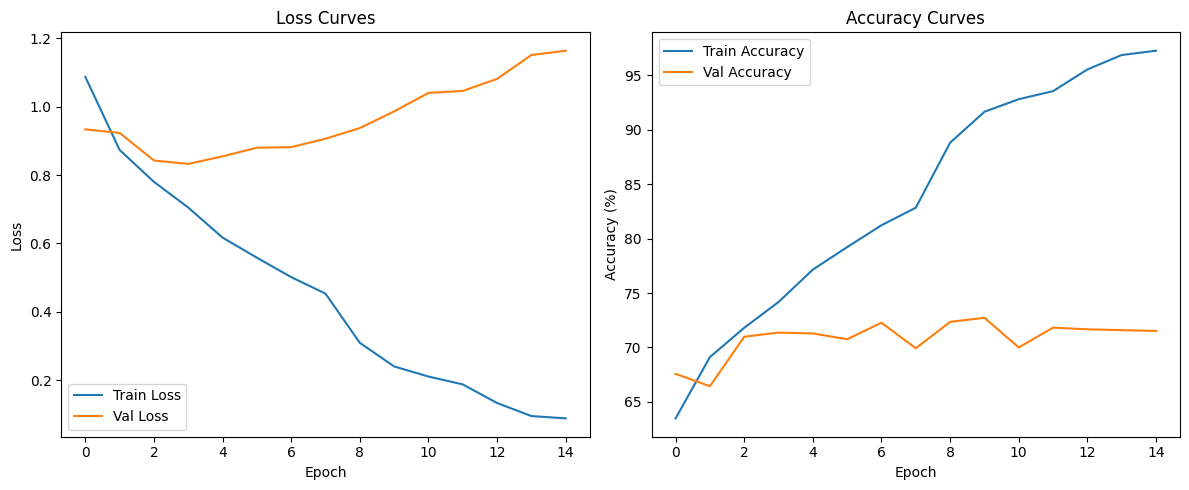

Training completed with best validation accuracy: 72.73%


In [17]:
def train_model(model, train_loader, val_loader, num_epochs=10, early_stop_patience=7):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    best_val_acc = 0.0
    best_model_wts = model.state_dict().copy()

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    no_improvement_counter = 0  # for early stopping

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

        # Validate
        val_loss, val_acc, all_preds, all_labels = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Scheduler step
        scheduler.step(val_loss)

        # Check for improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict().copy()
            no_improvement_counter = 0  # reset counter
            print(f"New best model with validation accuracy: {val_acc:.2f}%")
        else:
            no_improvement_counter += 1
            print(f"No improvement for {no_improvement_counter} epoch(s).")

        # Early stopping condition
        if no_improvement_counter >= early_stop_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curves')
    plt.tight_layout()
    plt.show()

    return model, best_val_acc

# Run training with 50 epochs and early stopping
num_epochs = 50
early_stop_patience = 5
finetuned_model, best_acc = train_model(model, train_loader, val_loader, num_epochs=num_epochs, early_stop_patience=early_stop_patience)

print(f"Training completed with best validation accuracy: {best_acc:.2f}%")


In [18]:
def save_model(model, save_path):
    """Save the model to the specified path"""
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))

    # Save the model
    if hasattr(model, 'save_pretrained'):
        # For transformers models
        model.save_pretrained(save_path)
        print(f"Model saved to {save_path} using save_pretrained")
    else:
        # For regular PyTorch models
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path} using torch.save")

# Save the model
save_path = '/content/finetuned_fer_model.safetensors'
save_model(finetuned_model, save_path)

Model saved to /content/finetuned_fer_model.safetensors using save_pretrained


Predicted expression: Happy with 90.04% confidence


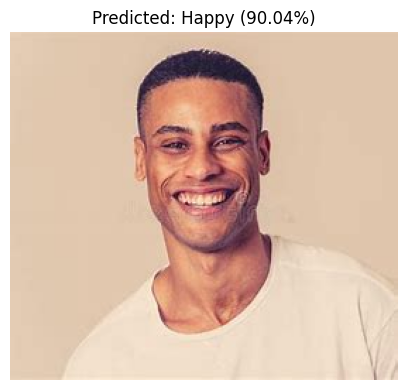

In [36]:
def predict_expression(model, image_path, transform=None, device=None):
    """
    Predict the facial expression in an image

    Args:
        model: The trained model
        image_path: Path to the image file
        transform: Transformation to apply to the image
        device: Device to run inference on

    Returns:
        Predicted class name and confidence score
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    model.to(device)

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')

    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        if hasattr(outputs, 'logits'):
            outputs = outputs.logits

        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
        confidence, predicted_idx = torch.max(probabilities, 0)

    # Get class names
    class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

    predicted_class = class_names[predicted_idx.item()]
    confidence_score = confidence.item() * 100

    return predicted_class, confidence_score

# Test the model on a sample image
sample_image_path = '/content/pic.jpeg'  # Update this to your test image path

if os.path.exists(sample_image_path):
    predicted_class, confidence = predict_expression(
        finetuned_model,
        sample_image_path,
        transform=val_transform,
        device=device
    )

    print(f"Predicted expression: {predicted_class} with {confidence:.2f}% confidence")

    # Display the image with prediction
    image = Image.open(sample_image_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()
else:
    print(f"Sample image not found at {sample_image_path}")

In [24]:
def evaluate_test_set(model, test_dir, transform=None, device=None):
    """
    Evaluate the model on a test dataset

    Args:
        model: The trained model
        test_dir: Directory containing test images
        transform: Transformation to apply to images
        device: Device to run evaluation on
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if transform is None:
        transform = val_transform

    # Create test dataset and dataloader
    test_dataset = FacialExpressionDataset(test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

    # Evaluate
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc, all_preds, all_labels = validate(model, test_loader, criterion, device)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    # Print classification report
    class_names = test_dataset.classes
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return test_acc

# Evaluate on test set if available
test_dir = '/content/cropped_faces_yolo_512_padded_1'  # Update this to your test dataset path

if os.path.exists(test_dir):
    test_acc = evaluate_test_set(finetuned_model, test_dir, transform=val_transform, device=device)
    print(f"Final test accuracy: {test_acc:.2f}%")
else:
    print(f"Test directory not found at {test_dir}")

Test directory not found at /content/cropped_faces_yolo_512_padded_1
